# Contents

----

----

__This notebook investigates Breast Cancer prediction data derived from `Ming et al.` (Gail model). Inductive Conformal Prediction is applied to the underlying classifier: `Logistic Regression`.__

$H_0$ = There is no difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

$H_a$ = There is a difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

----

In [101]:
import os

# set pwd to root of repository
repo_root = 'C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/'

os.chdir(repo_root)

In [102]:
# 'vigilant-computing-machine/source/util.py'
import source.util as util

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import Orange
from Orange.distance import Euclidean
import orangecontrib.conformal as cp

# Read in Data

In [103]:
normalizer = Orange.preprocess.Normalizer(norm_type = Orange.preprocess.Normalize.NormalizeBySD)
tab_signal = normalizer(Orange.data.Table('./data/signal_with_header_for_orange.csv'))

In [104]:
tab_signal.domain

[T1, N_Biop, HypPlas, AgeMen, Age1st, N_Rels, Race | Case_signalYN]

----
__Get `Race` distribution and cancer occurrence in population sample (Ming et al.)__

In [105]:
# get distribution of race
df_race_signal = pd.DataFrame()
df_race_signal['race'] = tab_signal.X[:,-1].astype(int)
df_race_signal_counts = df_race_signal.value_counts().sort_index()
n_signal_race = df_race_signal_counts.values.sum()

# get occurrence of cancer by race
df_race_signal['cancer'] = tab_signal.Y.astype(int)
p_cancer_by_race = df_race_signal.groupby('race').mean('cancer')

df_race_signal_prop = pd.DataFrame({'count_n': df_race_signal_counts,
                                    'count_p': df_race_signal_counts / n_signal_race,                                    
                                    'cancer': p_cancer_by_race.values.flatten()})
df_race_signal_prop

,count_n,count_p,cancer
race,,,
0,589,0.490833,0.490662
1,234,0.195000,0.478632
2,260,0.216667,0.526923
3,94,0.078333,0.510638
4,17,0.014167,0.647059
5,4,0.003333,0.500000
6,2,0.001667,0.000000


__Observation__:


The dataset above (Ming et al.) does not appear representative of many pathologies subject to Predictive Analytics in the Clinical Sciences.

The dataset above was intended to compare modern Machine Learning techniques to the traditional Gail model. 

Within the original context, the Breast Cancer prevalence of approximately 50% makes sense.

In the Clincial Sciences, a large number of pathologies subject to Predictive Analytics are much less prevalent.

----

__Mitigation__:


We will randomly remove 9/10 cancer cases; however, this may further diminish the quanitity of individuals belonging to minority races.

This will create class imbalance (10:1), which is more representative (relatively) of the prevalence of pathologies such as Breast Cancer.

----

__Note__:

We will later see that, in either case (balanced/imbalanced), the particular individuals in the less prevalent minority races happen to have risk-factor values that (when combined with the prevalence of cancer among members of the race) lead to high-confidence predictions.

Subsequently, we generate a larger population sample using the same procedure employed to create the original data (Ming et al.).

With a larger (ten-fold) sample size, we can more reasonably expect to have a viable representation of minority races, as well as being able to maintain this representation of minority races when randomly removing 9/10 cancer cases.

----
__Randomly remove 9/10 cancer cases__

In [106]:
# probability of getting breast cancer is not ~50-50

# get non-cancer
non_cancer_indices = np.array([x.row_index for x in tab_signal if x.get_class().value == '0'])

# get cancer (randomized, but reproducible)
cancer_indices = np.array([x.row_index for x in tab_signal if x.get_class().value == '1'])
cancer_indices_randomized = np.random.default_rng(42).permutation(cancer_indices)

# get 1 in 10 cancer
cancer_indices_tenth = cancer_indices_randomized[-int(len(cancer_indices) / 10):]

# create new table with cancer:non-cancer == 1/10:1
tab_decimated = Orange.data.Table.from_table_rows(tab_signal, 
                                                  np.concatenate([cancer_indices_tenth, 
                                                                  non_cancer_indices]))

tab_signal.name = 'Ming et al.'
tab_decimated.name = 'Ming et al. (cancer-decimated)'

----
__Get `Race` distribution and cancer occurrence in population sample (10:1 healthy:cancer)__

In [108]:
# get distribution of race
df_race_signal_dec = pd.DataFrame()
df_race_signal_dec['race'] = tab_decimated.X[:,-1].astype(int)
df_race_signal_dec_counts = df_race_signal_dec.value_counts().sort_index()
n_signal_race = df_race_signal_dec_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_dec['cancer'] = tab_decimated.Y.astype(int)
p_cancer_by_race = df_race_signal_dec.groupby('race').mean('cancer')

df_race_signal_decimated_prop = pd.DataFrame({'count_n': df_race_signal_dec_counts,
                                              'count_p': df_race_signal_dec_counts / n_signal_race,                                    
                                              'cancer': p_cancer_by_race.values.flatten()})

# add race count
df_race_signal_prop['count_n_dec'] = df_race_signal_dec_counts

# add race proportion
df_race_signal_prop['count_p_dec'] = df_race_signal_dec_counts / n_signal_race

# add race cancer prevalence
df_race_signal_prop['cancer_dec'] =  p_cancer_by_race.values.flatten()

# reorder
df_race_signal_prop = df_race_signal_prop.iloc[:,[0,3,2,5,1,4]]
df_race_signal_prop

,count_n,count_n_dec,cancer,cancer_dec,count_p,count_p_dec
race,,,,,,
0,589,335,0.490662,0.104478,0.490833,0.507576
1,234,131,0.478632,0.068702,0.195000,0.198485
2,260,132,0.526923,0.068182,0.216667,0.200000
3,94,52,0.510638,0.115385,0.078333,0.078788
4,17,6,0.647059,0.000000,0.014167,0.009091
5,4,2,0.500000,0.000000,0.003333,0.003030
6,2,2,0.000000,0.000000,0.001667,0.003030


__Note__:

The small number of individuals belonging to `race` 4, 5, and 6--combined with the lack of these any of individuals having cancer (`cancer_dec`)--may exacerbate any existing uncertainty in making the corresponding predictions.

## Get Cancer Correlation with Independent Variables

In [109]:
df_tab_signal = util.table_to_df(tab_signal, x_only=False)
df_cancer_X_correlation_matrix_signal = pd.DataFrame(df_tab_signal.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix_signal

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


In [110]:
df_tab_signal_decimated = util.table_to_df(tab_decimated, x_only=False)
df_cancer_X_correlation_matrix_signal_dec = pd.DataFrame(df_tab_signal_decimated.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix_signal_dec

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.584841,0.106319,-0.088406,0.055188,-0.004393,0.081889,-0.040239,1.0


__Observation__:


Majority of the correlation coefficients retain their respective proportions and sign change only occurred on the two least correlated variables.

As noted above, we see the lack of any individuals belonging to `race` 4/5/6 having cancer may be contributing to the correlation between `Race` and `Case_signalYN` (cancer) becoming slightly negative. 

Subsequently, we repeat the following experiments with a larger dataset.

This is a fairly reasonable result and we shall proceed.

----

__Experiment__:

We will utilize Logistic Regression as our underlying classifier.

We will pair this classifier with a the general-purpose nonconformity measure (`InverseProbability`) $1 - p$, where $p$ is the probability assigned to the actual class by the underlying classifier.

This pairing will be used to construct an Inductive Conformal Predictor (`InductiveClassifier`).

An Inductive Conformal Predictor will be constructed for each dataset above (healthy:cancer - 1:1 and 10:1).

Each Inductive Conformal Predictor will be fit, calibrated, and used to make predictions.

We will then evaluate the relationship between the lowest `confidence`/`credibility` predictions, respectively, and `race`.

# Ming et al. Data 
----

(original n=1200; cancer-decimated n=660)

----

----

----

## Logistic Regression (split)
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.986101,0.497341,0.96,0.0,0.925,0.885,0.075,Ming et al.,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Split Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ ...


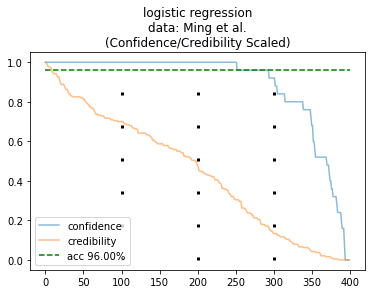

In [111]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1)) # 2:1 train:test
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1)) # 2:1 train:calibrate

cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_signal = util.run_experiments(cc, 
                                                  train, 
                                                  test, 
                                                  calibrate,
                                                  eps=0.05, 
                                                  method='Baseline Split Data')

util.plot_experiments(experiment_logistic_signal)
experiment_logistic_signal

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.989036,0.558538,0.990909,0.0,0.972727,0.963636,0.027273,Ming et al. (cancer-decimated),False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Split Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ ...


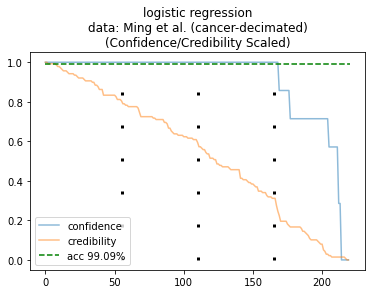

In [112]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_decimated,2,1)) # 2:1 train:test
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1)) # 2:1 train:calibrate

cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_cancer_decimated = util.run_experiments(cc, 
                                                            train, 
                                                            test, 
                                                            calibrate, 
                                                            eps=0.05, 
                                                            method='Baseline Split Data')

util.plot_experiments(experiment_logistic_cancer_decimated)
experiment_logistic_cancer_decimated

__Observation__:

In the cancer-decimated experiment, `confidence` was sustained longer and fell more sharply, as expected, than the (1:1 healthy:cancer) Ming et al. dataset experiment.

---
__Get Lower Decile Range (LDR) Predictions - `confidence`/`credibility`__

In [130]:
df_pred = experiment_logistic_signal.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
399,"[0, 1]",0.902985,0.100746,0.05,"[(0.10074626865671642, 0), (0.0970149253731343...",True,0.0845,0,2,0.51721,-0.543679,0,0,0


In [131]:
df_pred = experiment_logistic_cancer_decimated.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_cancer_decimated_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_cancer_decimated_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
219,"[0, 1]",0.945946,0.054054,0.05,"[(0.05405405405405406, 0), (0.0540540540540540...",True,0.482929,3,1,-0.440587,-0.474771,0,0,1


----
__Get `Race` distribution in LDR__

In [142]:
# 1:1 healthy:cancer (split)
counts = df_pred_logistic_signal_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_split': counts / sums,
                            'ldr_n_split': counts})
table = df_race_signal_prop.join(proportions, 
                                 on='race', 
                                 how='left')
table = table.fillna(0)
table['ldr_n_split'] = table['ldr_n_split'].astype(int)
df_logistic_ldr_race_disparity = table.copy()
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.iloc[:, [0,1,7,2,3,4,5,6]]


# 10:1 healthy:cancer (split)
counts = df_pred_logistic_signal_cancer_decimated_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_dec_split': counts / sums, 
                            'ldr_n_dec_split': counts})
table = df_logistic_ldr_race_disparity.join(proportions, 
                                            on='race', 
                                            how='left')
table = table.fillna(0)
table['ldr_n_dec_split'] = table['ldr_n_dec_split'].astype(int)
df_logistic_table = table.copy()
df_logistic_table = df_logistic_table.iloc[:, [0,1,2,9,3,4,5,6,7,8]]
df_logistic_table

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split
race,,,,,,,,,,
0,589,335,22,9,0.490662,0.104478,0.490833,0.507576,0.550,0.409091
1,234,131,8,4,0.478632,0.068702,0.195000,0.198485,0.200,0.181818
2,260,132,7,4,0.526923,0.068182,0.216667,0.200000,0.175,0.181818
3,94,52,3,5,0.510638,0.115385,0.078333,0.078788,0.075,0.227273
4,17,6,0,0,0.647059,0.000000,0.014167,0.009091,0.000,0.000000
5,4,2,0,0,0.500000,0.000000,0.003333,0.003030,0.000,0.000000
6,2,2,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000


__Observation__:

We can see that when there is class imbalance (10:1 healthy:cancer), the minority race predictions in the LDR are either fairly representative, not present at all, or the race is __significantly over-represented__ in the low confidence region.

In both experiments, the sparsest three minority races are not present in the LDR.

A large factor at play, aside from the risk factors of individual minorities, is the small number of minorities and the fact that the population was split into train/test/calibrate sets.

Splitting the data in this way introduces bias, as well as the possibility that entire minority races are placed within one of the three groups.

For example, if the entirety of individuals belonging to a race ends up in the train set, there will be no predictions made for this race in general--without regard to confidence.

__Mitigation__:

We will proceed by using the entirety of the population sample for training, calibration, and testing, removing a source of bias and solely focusing on Conformal Prediction attributes (primarily confidence) and how they vary with respect to non-uniformly distributed features (primarily race).

## Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.993566,0.506468,0.950833,0.0,0.97,0.920833,0.03,Ming et al.,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \...


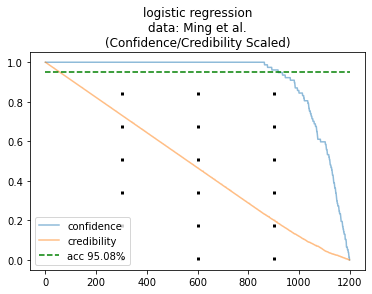

In [138]:
np.random.seed(42)


cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_signal = util.run_experiments(cc, 
                                                  tab_signal, 
                                                  tab_signal, 
                                                  tab_signal,
                                                  eps=0.05, 
                                                  method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic_signal)
experiment_logistic_signal

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.997405,0.502732,0.951515,0.037879,0.962121,0.951515,0.0,Ming et al. (cancer-decimated),False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ ...


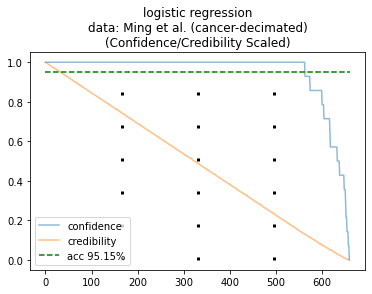

In [139]:
np.random.seed(42)


cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_cancer_decimated = util.run_experiments(cc, 
                                                            tab_decimated, 
                                                            tab_decimated, 
                                                            tab_decimated, 
                                                            eps=0.05, 
                                                            method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic_cancer_decimated)
experiment_logistic_cancer_decimated

__Observation__:

In the cancer-decimated experiment, `confidence` continued to be sustained longer and fall more sharply, as expected, than the (1:1 healthy:cancer) Ming et al. dataset experiment.

---
__Get Lower Decile Range (LDR) Predictions - `confidence`/`credibility`__

In [143]:
df_pred = experiment_logistic_signal.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, 
                                            col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1199,"[0, 1]",0.935054,0.064946,0.05,"[(0.0649458784346378, 0), (0.0649458784346378,...",True,0.0845,0,2,0.51721,-0.336957,0,1,1


In [144]:
df_pred = experiment_logistic_cancer_decimated.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, 
                                                             col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_cancer_decimated_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_cancer_decimated_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
659,[],0.977307,0.022693,0.05,"[(0.0226928895612708, 0), (0.0226928895612708,...",False,0.482929,0,2,0.51721,2.040345,0,1,1


----
__Get `Race` distribution in LDR__

In [151]:
# 1:1 healthy:cancer (unsplit)
counts = df_pred_logistic_signal_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_unsplit': counts / sums,
                            'ldr_n_unsplit': counts})
table = df_logistic_table.join(proportions, 
                               on='race', 
                               how='left')
table = table.fillna(0)
table['ldr_n_unsplit'] = table['ldr_n_unsplit'].astype(int)
df_logistic_ldr_race_disparity_unsplit = table.copy()
df_logistic_table = df_logistic_ldr_race_disparity_unsplit.iloc[:, [0,1,2,3,11,4,5,6,7,8,9,10]]

# 10:1 healthy:cancer (unsplit)
counts = df_pred_logistic_signal_cancer_decimated_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_dec_unsplit': counts / sums, 
                            'ldr_n_dec_unsplit': counts})
table = df_logistic_table.join(proportions, 
                               on='race', 
                               how='left')
table = table.fillna(0)
table['ldr_n_dec_unsplit'] = table['ldr_n_dec_unsplit'].astype(int)
df_logistic_signal_cancer_decimated_ldr_race_disparity_unsplit = table.copy()
df_logistic_table = df_logistic_signal_cancer_decimated_ldr_race_disparity_unsplit.iloc[:, [0,1,2,3,4,13,5,6,7,8,9,10,11,12]]
df_logistic_table

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,ldr_n_unsplit,ldr_n_dec_unsplit,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split,ldr_p_unsplit,ldr_p_dec_unsplit
race,,,,,,,,,,,,,,
0,589,335,22,9,50,42,0.490662,0.104478,0.490833,0.507576,0.550,0.409091,0.416667,0.636364
1,234,131,8,4,33,11,0.478632,0.068702,0.195000,0.198485,0.200,0.181818,0.275000,0.166667
2,260,132,7,4,25,4,0.526923,0.068182,0.216667,0.200000,0.175,0.181818,0.208333,0.060606
3,94,52,3,5,12,8,0.510638,0.115385,0.078333,0.078788,0.075,0.227273,0.100000,0.121212
4,17,6,0,0,0,1,0.647059,0.000000,0.014167,0.009091,0.000,0.000000,0.000000,0.015152
5,4,2,0,0,0,0,0.500000,0.000000,0.003333,0.003030,0.000,0.000000,0.000000,0.000000
6,2,2,0,0,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000,0.000000,0.000000


In [278]:
df_logistic_table.loc[:, ['count_p', 'ldr_p_split', 'ldr_p_unsplit', 'count_p_dec', 'ldr_p_dec_split', 'ldr_p_dec_unsplit']]

,count_p,ldr_p_split,ldr_p_unsplit,count_p_dec,ldr_p_dec_split,ldr_p_dec_unsplit
race,,,,,,
0,0.490833,0.550,0.416667,0.507576,0.409091,0.636364
1,0.195000,0.200,0.275000,0.198485,0.181818,0.166667
2,0.216667,0.175,0.208333,0.200000,0.181818,0.060606
3,0.078333,0.075,0.100000,0.078788,0.227273,0.121212
4,0.014167,0.000,0.000000,0.009091,0.000000,0.015152
5,0.003333,0.000,0.000000,0.003030,0.000000,0.000000
6,0.001667,0.000,0.000000,0.003030,0.000000,0.000000


__Observation__:

We can see that we get results that tend to appear more extreme than the prior train/test/calibration split experiment results.

It is notable that we are still not getting any instances of our 2-3 most-extreme minority races in the low confidence region.

The small quantity of individuals belonging to these races, in either case (balanced/imbalanced), in combination with the particular individuals' risk factor values and the prevalence of cancer in each race, appears to be leading to predictions that are not of low confidence.

__Mitigation__:

Subsequently, we generate a larger population sample using the same (Ming et al.) procedure.

Given a larger (ten-fold) sample, we can more reasonably expect to capture a viable representation of minority races, as well as being able to maintain this representation of minority races when randomly removing 9/10 cancer cases from the sample.

----

----

----

# Read in Data (10x sample size)

In [46]:
tab_10x = normalizer(Orange.data.Table('./data/signal_10x_with_header_for_orange.csv'))

----
__Get `Race` distribution and cancer occurrence in population sample__

In [158]:
# get distribution of race
df_race_signal_10x = pd.DataFrame()
df_race_signal_10x['race'] = tab_10x.X[:,-1].astype(int)
df_race_signal_10x_counts = df_race_signal_10x.value_counts().sort_index()
n_signal_race = df_race_signal_10x_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_10x['cancer'] = tab_10x.Y.astype(int)
p_cancer_by_race = df_race_signal_10x.groupby('race').mean('cancer')

df_race_signal_10x_prop = pd.DataFrame({'count_n_10x': df_race_signal_10x_counts,
                                        'count_p_10x': df_race_signal_10x_counts / n_signal_race,                                    
                                        'cancer_10x': p_cancer_by_race.values.flatten()})
df_race_signal_10x_prop

,count_n_10x,count_p_10x,cancer_10x
race,,,
0,6043,0.503583,0.505378
1,2397,0.199750,0.487693
2,2366,0.197167,0.502959
3,935,0.077917,0.499465
4,126,0.010500,0.436508
5,68,0.005667,0.352941
6,65,0.005417,0.476923


----
__Randomly remove 9/10 cancer cases__

In [50]:
# probability of getting breast cancer is not ~50-50

# get non-cancer
non_cancer_indices = np.array([x.row_index for x in tab_10x if x.get_class().value == '0'])

# get cancer (randomized, but reproducible)
cancer_indices = np.array([x.row_index for x in tab_10x if x.get_class().value == '1'])
cancer_indices_randomized = np.random.default_rng(42).permutation(cancer_indices)

# get 1 in 10 cancer
cancer_indices_tenth = cancer_indices_randomized[-int(len(cancer_indices) / 10):]

# create new table with cancer:non-cancer == 1/10:1
tab_10x_decimated = Orange.data.Table.from_table_rows(tab_10x, 
                                                      np.concatenate([cancer_indices_tenth, 
                                                                      non_cancer_indices]))

tab_10x.name = 'Ming et al. (10x)'
tab_10x_decimated.name = 'Ming et al. (10x, cancer-decimated)'

----
__Get `Race` distribution and cancer occurrence in population sample (10:1 healthy:cancer)__

In [177]:
# get distribution of race
df_race_signal_10x_dec = pd.DataFrame()
df_race_signal_10x_dec['race'] = tab_10x_decimated.X[:,-1].astype(int)
df_race_signal_10x_dec_counts = df_race_signal_10x_dec.value_counts().sort_index()
n_signal_race = df_race_signal_10x_dec_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_10x_dec['cancer'] = tab_10x_decimated.Y.astype(int)
p_cancer_by_race = df_race_signal_10x_dec.groupby('race').mean('cancer')

df_race_signal_10x_decimated_prop = pd.DataFrame({'count_n_10x_dec': df_race_signal_10x_dec_counts,
                                                  'count_p_10x_dec': df_race_signal_10x_dec_counts / n_signal_race,                                    
                                                  'cancer_10x_dec': p_cancer_by_race.values.flatten()})
table = pd.concat([df_race_signal_10x_prop, df_race_signal_10x_decimated_prop], axis=1)
table_10x = table.iloc[:, [0,3,2,5,1,4]]
table_10x

,count_n_10x,count_n_10x_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec
race,,,,,,
0,6043,3313,0.505378,0.097797,0.503583,0.501286
1,2397,1337,0.487693,0.081526,0.199750,0.202300
2,2366,1283,0.502959,0.083398,0.197167,0.194129
3,935,510,0.499465,0.082353,0.077917,0.077167
4,126,80,0.436508,0.112500,0.010500,0.012105
5,68,45,0.352941,0.022222,0.005667,0.006809
6,65,41,0.476923,0.170732,0.005417,0.006204


## Get Cancer Correlation with Independent Variables

In [ ]:
df_tab_10x = util.table_to_df(tab_10x, x_only=False)
df_cancer_X_correlation_matrix_signal_10x = pd.DataFrame(df_tab_10x.corr().iloc[-1, :]).T

df_tab_10x_decimated = util.table_to_df(tab_10x_decimated, x_only=False)
df_cancer_X_correlation_matrix_signal_10x_dec = pd.DataFrame(df_tab_10x_decimated.corr().iloc[-1, :]).T

----

In [54]:
df_cancer_X_correlation_matrix_signal  # 1:1 - healthy:cancer (n=1200)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


In [55]:
df_cancer_X_correlation_matrix_signal_dec  # 10:1 - healthy:cancer (n=1200)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.584841,0.106319,-0.088406,0.055188,-0.004393,0.081889,-0.040239,1.0


In [52]:
df_cancer_X_correlation_matrix_signal_10x  # 1:1 healthy:cancer (n=12000)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.767549,0.081638,-0.073791,0.050976,-0.004405,0.061774,-0.014273,1.0


In [53]:
df_cancer_X_correlation_matrix_signal_10x_dec  # 10:1 healthy:cancer (n=12000)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.567539,0.047534,-0.033543,0.012155,0.001164,0.046679,-0.014438,1.0


The impact on correlation coefficients is consistent with the prior experiment.

The correlation coefficients, by and large, retain their respective proportions and sign change only occurrs for the single most weakly correlated variable.

This is a reasonable result.

As such, we shall proceed.

# Ming et al. Data (10x)
----

(original n=12000; cancer-decimated n=6609)

----

----

----

## Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.991913,0.508163,0.950083,0.0,0.93375,0.883833,0.06625,Ming et al. (10x),False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline 10x Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps ...


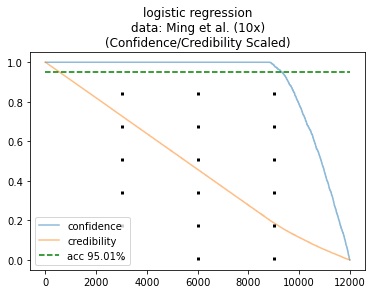

In [63]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_signal_10x = util.run_experiments(cc, 
                                                      tab_10x, 
                                                      tab_10x, 
                                                      tab_10x, 
                                                      eps=0.05, 
                                                      method='Baseline 10x Unsplit Data')

util.plot_experiments(experiment_logistic_signal_10x)
experiment_logistic_signal_10x

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.99814,0.502021,0.950219,0.036314,0.963686,0.950219,0.0,"Ming et al. (10x, cancer-decimated)",False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),Baseline 10x Unsplit Data,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \...


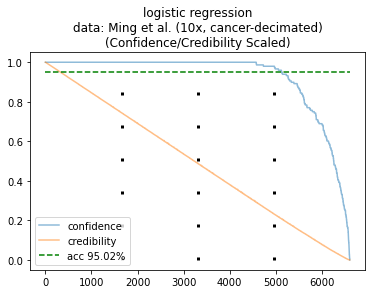

In [72]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_10x_decimated = util.run_experiments(cc, 
                                                         tab_10x_decimated,                                            
                                                         tab_10x_decimated, 
                                                         tab_10x_decimated, 
                                                         eps=0.05, 
                                                         method='Baseline 10x Unsplit Data')

util.plot_experiments(experiment_logistic_10x_decimated)
experiment_logistic_10x_decimated

---
__Get Lower Decile Range (LDR) Predictions - `confidence`/`credibility`__

In [154]:
df_pred = experiment_logistic_signal_10x.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_10x_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_10x_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
11999,"[0, 1]",0.92209,0.07791,0.05,"[(0.07791017415215398, 0), (0.0779101741521539...",True,-0.293725,2,0,2.407616,-0.416625,0,0,0


In [155]:
df_pred = experiment_logistic_10x_decimated.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_10x_decimated_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_10x_decimated_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
6608,[],0.977458,0.022542,0.05,"[(0.02254160363086233, 0), (0.0225416036308623...",False,0.301329,0,2,1.442897,-0.416625,0,0,1


----
__Get `Race` distribution in LDR__

In [183]:
# 1:1 healthy:cancer
counts = df_pred_logistic_signal_10x_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_10x_unsplit': counts / sums,
                            'ldr_n_10x_unsplit': counts})
table = table_10x.join(proportions, 
                       on='race', 
                       how='left')
table = table.fillna(0)
table['ldr_n_10x_unsplit'] = table['ldr_n_10x_unsplit'].astype(int)
df_logistic_ldr_race_disparity_10x = table.copy()
df_logistic_table_10x = df_logistic_ldr_race_disparity_10x.iloc[:, [0,1,7,2,3,4,5,6]]

# 10:1 healthy:cancer
counts = df_pred_logistic_10x_decimated_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_10x_unsplit_dec': counts / sums,
                            'ldr_n_10x_unsplit_dec': counts})
table = df_logistic_table_10x.join(proportions, 
                                   on='race', 
                                   how='left')
table = table.fillna(0)
table['ldr_n_10x_unsplit_dec'] = table['ldr_n_10x_unsplit_dec'].astype(int)
df_logistic_ldr_race_disparity_10x_decimated = table.copy()
df_logistic_table_10x = df_logistic_ldr_race_disparity_10x_decimated.iloc[:, [0,1,2,9,3,4,5,6,7,8]]
df_logistic_table_10x

,count_n_10x,count_n_10x_dec,ldr_n_10x_unsplit,ldr_n_10x_unsplit_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec,ldr_p_10x_unsplit,ldr_p_10x_unsplit_dec
race,,,,,,,,,,
0,6043,3313,587,353,0.505378,0.097797,0.503583,0.501286,0.489167,0.534848
1,2397,1337,249,121,0.487693,0.081526,0.199750,0.202300,0.207500,0.183333
2,2366,1283,246,107,0.502959,0.083398,0.197167,0.194129,0.205000,0.162121
3,935,510,85,54,0.499465,0.082353,0.077917,0.077167,0.070833,0.081818
4,126,80,17,13,0.436508,0.112500,0.010500,0.012105,0.014167,0.019697
5,68,45,7,3,0.352941,0.022222,0.005667,0.006809,0.005833,0.004545
6,65,41,9,9,0.476923,0.170732,0.005417,0.006204,0.007500,0.013636


In [280]:
# n=1200
# 1:1 race proportion sample vs low-confidence
# 10:1 race proportion sample vs low-confidence
df_logistic_table.loc[:, 'cancer':].iloc[:, [2,6,3,7]]

,count_p,ldr_p_unsplit,count_p_dec,ldr_p_dec_unsplit
race,,,,
0,0.490833,0.416667,0.507576,0.636364
1,0.195000,0.275000,0.198485,0.166667
2,0.216667,0.208333,0.200000,0.060606
3,0.078333,0.100000,0.078788,0.121212
4,0.014167,0.000000,0.009091,0.015152
5,0.003333,0.000000,0.003030,0.000000
6,0.001667,0.000000,0.003030,0.000000


In [195]:
# n=12000
# 1:1 race proportion sample vs low-confidence
# 10:1 race proportion sample vs low-confidence
df_logistic_table_10x.loc[:, 'cancer_10x':].iloc[:, [2,4,3,5]]

,count_p_10x,ldr_p_10x_unsplit,count_p_10x_dec,ldr_p_10x_unsplit_dec
race,,,,
0,0.503583,0.489167,0.501286,0.534848
1,0.199750,0.207500,0.202300,0.183333
2,0.197167,0.205000,0.194129,0.162121
3,0.077917,0.070833,0.077167,0.081818
4,0.010500,0.014167,0.012105,0.019697
5,0.005667,0.005833,0.006809,0.004545
6,0.005417,0.007500,0.006204,0.013636


----

----
__Plot population sample race distribution vs low confidence prediction race distribution__

We can see that with the data in our original sample of size of 1,200 (Ming et al.) we did not encounter a set of predictions where at least one instance of each race was present in the LDR (low confidence region).

Subsequently, we generated a sample of size 12,000--using the same procedure (Ming et al.)--and performed the (unsplit) 1:1 and 10:1 (health:cancer) experiments with this data.

### Results `n=1200`

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,ldr_n_unsplit,ldr_n_dec_unsplit,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split,ldr_p_unsplit,ldr_p_dec_unsplit
race,,,,,,,,,,,,,,
0,589,335,22,9,50,42,0.490662,0.104478,0.490833,0.507576,0.550,0.409091,0.416667,0.636364
1,234,131,8,4,33,11,0.478632,0.068702,0.195000,0.198485,0.200,0.181818,0.275000,0.166667
2,260,132,7,4,25,4,0.526923,0.068182,0.216667,0.200000,0.175,0.181818,0.208333,0.060606
3,94,52,3,5,12,8,0.510638,0.115385,0.078333,0.078788,0.075,0.227273,0.100000,0.121212
4,17,6,0,0,0,1,0.647059,0.000000,0.014167,0.009091,0.000,0.000000,0.000000,0.015152
5,4,2,0,0,0,0,0.500000,0.000000,0.003333,0.003030,0.000,0.000000,0.000000,0.000000
6,2,2,0,0,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000,0.000000,0.000000


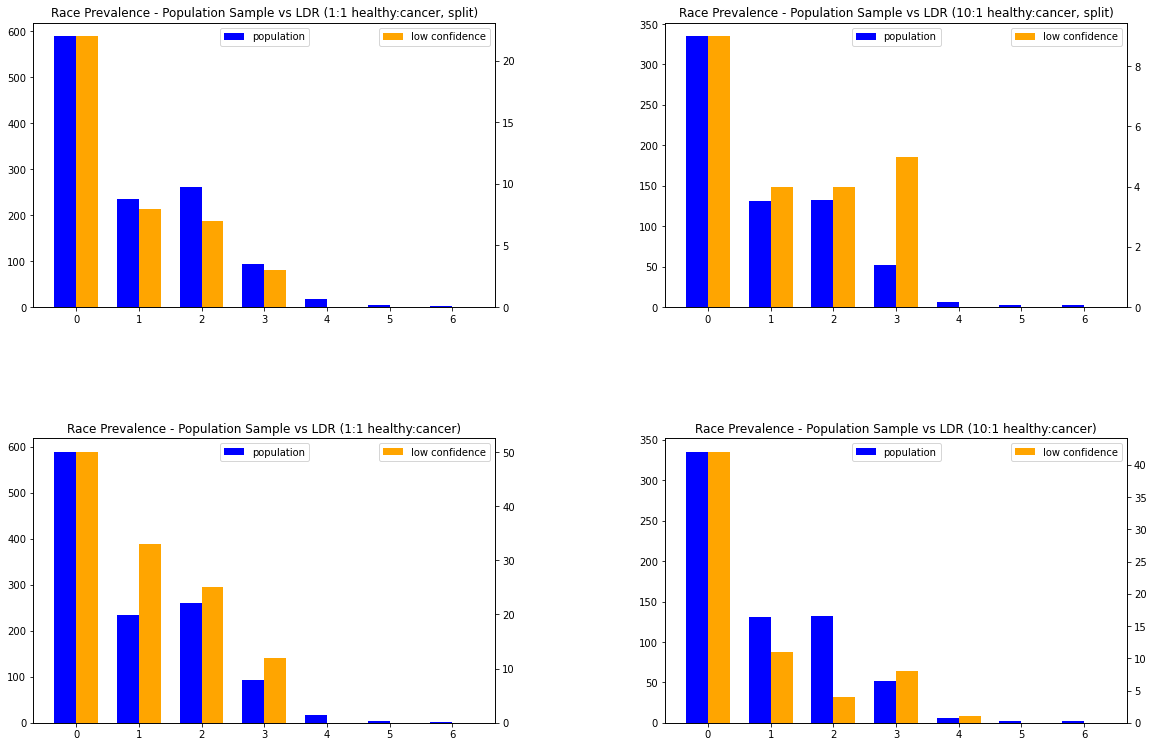

In [237]:
fig, axs = plt.subplots(2, 2)

ax = axs[0,0]
x = np.arange(len(df_logistic_table.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table.count_n.sort_index().values
lcr_race = df_logistic_table.ldr_n_split.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (1:1 healthy:cancer, split)')

ax = axs[0,1]
x = np.arange(len(df_logistic_table.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table.count_n_dec.sort_index().values
lcr_race = df_logistic_table.ldr_n_dec_split.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (10:1 healthy:cancer, split)')

ax = axs[1,0]
x = np.arange(len(df_logistic_table.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table.count_n.sort_index().values
lcr_race = df_logistic_table.ldr_n_unsplit.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (1:1 healthy:cancer)')

ax = axs[1,1]
x = np.arange(len(df_logistic_table.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table.count_n_dec.sort_index().values
lcr_race = df_logistic_table.ldr_n_dec_unsplit.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (10:1 healthy:cancer)')

fig.set_figwidth(18)
fig.set_figheight(12)
df_logistic_table

We can see that the results are not consistent or immediatly clear when using a population sample of 1,200.

This is, in large part, likely due to the small quantity of individuals belonging to the three least prevalent races.

In the 1:1 split/unsplit experiments, these three races total 23 individuals.

In the corresponding 10:1 split/unsplit experiments, these three races total 10 individuals.

Without quite strange risk-factor values for each of these individuals (including with respect to each other), the results observed from these experiments is to be expected.

Additionally, even if individuals of these races had unique and unusual risk-factor values, the train/test/calibrate split experiments introduce the possibility that some or all of these individuals end up in a part of the split for which predictions are not made (train/calibrate).

For these reasons, we removed the bias introduced by splitting the data and utilized a dataset less susceptible to under-representing the variance present in the sparser minority populations.

----

### Results `n=12000`

,count_n_10x,count_n_10x_dec,ldr_n_10x_unsplit,ldr_n_10x_unsplit_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec,ldr_p_10x_unsplit,ldr_p_10x_unsplit_dec
race,,,,,,,,,,
0,6043,3313,587,353,0.505378,0.097797,0.503583,0.501286,0.489167,0.534848
1,2397,1337,249,121,0.487693,0.081526,0.199750,0.202300,0.207500,0.183333
2,2366,1283,246,107,0.502959,0.083398,0.197167,0.194129,0.205000,0.162121
3,935,510,85,54,0.499465,0.082353,0.077917,0.077167,0.070833,0.081818
4,126,80,17,13,0.436508,0.112500,0.010500,0.012105,0.014167,0.019697
5,68,45,7,3,0.352941,0.022222,0.005667,0.006809,0.005833,0.004545
6,65,41,9,9,0.476923,0.170732,0.005417,0.006204,0.007500,0.013636


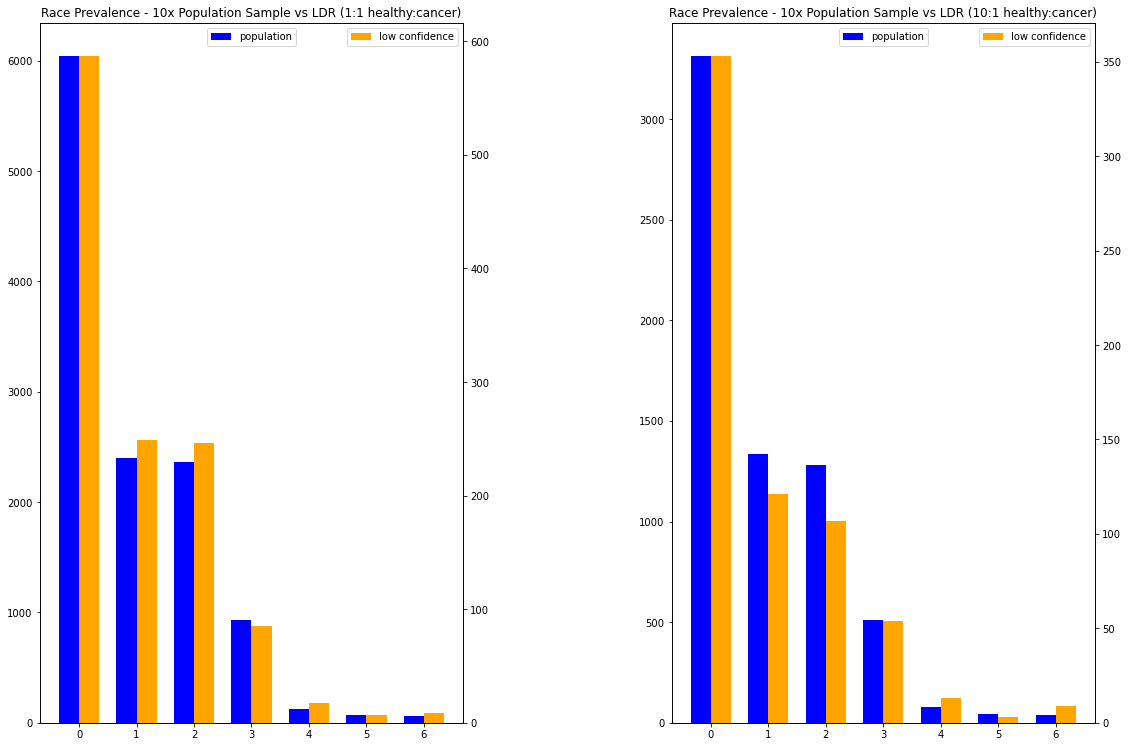

In [275]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
x = np.arange(len(df_logistic_table_10x.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table_10x.count_n_10x.sort_index().values
lcr_race = df_logistic_table_10x.ldr_n_10x_unsplit.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - 10x Population Sample vs LDR (1:1 healthy:cancer)')

ax = axs[1]
x = np.arange(len(df_logistic_table_10x.index))
ax_y2 = ax.twinx()
width = 0.35
pop_race = df_logistic_table_10x.count_n_10x_dec.sort_index().values
lcr_race = df_logistic_table_10x.ldr_n_10x_unsplit_dec.sort_index().values
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax_y2.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
ax_y2.legend()
fig.tight_layout()
ax.set_title('Race Prevalence - 10x Population Sample vs LDR (10:1 healthy:cancer)')

fig.set_figwidth(18)
fig.set_figheight(12)

df_logistic_table_10x

We can see that with the data in our sample of size of 12,000 (Ming et al.) we encounter at least one instance of each race in the LDR (low confidence region) for both (1:1 & 10:1) experiments.

Additionally, we observe that in both experiments:
- __Majority__ `race` 0 (__~50%__ of the population sample)
    - __Does not__ appear to tend toward __over-representation__ in the __low confidence region__ of either experiments' predictions
- __Minority__ `race` 4, 5, and 6 (each representing __< 1.25%__ of the sample)
    - __Does__ appear to tend toward __over-represention__ in the __low confidence region__ of both experiments' predictions
        - The exception is `race` 5 in the 10:1 experiment (0.58% vs 0.45%)
            - However, the small quantity of individuals belonging to this race (n=68) and the prevalence of cancer in individuals belonging to this race (1/68) may help account for the observed lack of low confidence predictions

----

----

----

----

----